Dataset available at:  
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

The Dataset provides information on 569 patients, their diagnosis, and 30 characteristics of their Fine Needle Aspirate (FNA) biopsy.  

An FNA is a procedure wherein a thin needle is used to collect sample cells from either a suspicious mass or a suspicious lymph node.  It typically follows a mammogram and it is relatively noninvasive.  The downside of an FNA is that there is a small sample collected, and drawing through a small needle destroys the architecture of the sample.  That is to say, we receive a sample of individual cells, and can characterize them with microscopy, but we cannot see how the cells fit in relation to one another.  Another option at this stage in diagnosis are the core needle biopsy, which uses a larger needle, yields a larger sample, and can preserve structure.  Should the FNA be positive, it would be followed by an excisional biopsy, or surgical resection.

Note here that the features refer to individual nuclei, their size, smoothness or their borders, etc.  These features are generated from digitized images.  

The goals here are:
* Data exploration, seeing what features are most predictive of malignancy.
* To apply classical, supervised, machine learning models
* Train a deep neural net with Keras
* Quantify the performance of these models.

Our models provide excellent accuracy and could be useful clinically.  Their use might include confirmation of pathologists readings.  Similarly if our model contradicts the pathologist, further diagnostic testing or consultation might be merited.  Our model, since it obtains excellent results, might be useful in underserved areas or undeveloped countries, where pathologists might not be available, but an FNA biopsy could be performed by a primary care provider.  

references:  
https://www.uptodate.com/contents/breast-biopsy  
https://onlinelibrary.wiley.com/doi/full/10.1002/cncy.21742

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
import sklearn as sk
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.decomposition import KernelPCA
import timeit

In [58]:
data = pd.read_csv(r'/home/david/keras/kaggle/data.csv')
display(data.head())
print(data.shape)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


(569, 33)


In [59]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [60]:
data.keys()

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [61]:
print(data.shape)
data_clean = data.drop(columns=['Unnamed: 32', 'id', 'diagnosis']) #Unnamed column from Pandas handling of index
print(data_clean.shape)

(569, 33)
(569, 30)


In [62]:
# check if we have any nan values in data
np.any(np.isnan(data_clean))

False

In [63]:
# check, for type uniformity in feature space
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 non-null float64
symmetry_se                569 

what shape to feed model?  

each sample has 30 features of type float64  
want numpy array of shape (samples, number of features) for up to 30 features

In [64]:
diag = data['diagnosis']
min(diag), max(diag)

('B', 'M')

In [65]:
# convert labels
def to_binary(input):
    ans = []
    for i in input:
        if i =='M':
            ans.append(1)
        else:
            ans.append(0)
    return ans

diag_bin = to_binary(diag)

In [66]:
# This normalizes the values, essentially it calculates the Z score
# How many standard deviations away from mean

data_norm = np.asarray(data_clean.copy())
for i in range(data_norm.shape[1]):
    mid = np.mean(data_norm[:,i])
    stand = np.std(data_norm[:,i])
    for j in range(data_norm.shape[0]):
        data_norm[j,i] -= mid
        data_norm[j,i] /= stand
data_norm[0][:5]

array([ 1.09706398, -2.07333501,  1.26993369,  0.9843749 ,  1.56846633])

In [67]:
# An alternative scaling method, this will collapse the feature space to [0,1]

data_scaled = np.asarray(data_clean.copy())
# data_train_norm.shape[0]
for i in range(data_norm.shape[1]):
    low = np.min(data_scaled[:,i])
    high = np.max(data_scaled[:,i])
    split = high - low
    for j in range(data_norm.shape[0]):
        data_scaled[j,i] -= low
        data_scaled[j,i] /= split
display(data_scaled[0][:5])

array([0.52103744, 0.0226581 , 0.54598853, 0.36373277, 0.59375282])

In [68]:
#train, test split 
#todo train,validate,test

data_train = data_norm[:455]
data_test = data_norm[455:]
diag_train = diag_bin[:455]
diag_test = diag_bin[455:]

In [69]:
data_train_scaled = data_scaled[:455]
data_test_scaled = data_scaled[455:]
diag_train = diag_bin[:455]
diag_test = diag_bin[455:]

In [70]:
# as a control, nonnormalized data
temp = np.asarray(data_clean.copy())
data_train_nonnormalized = temp[:455]
data_test_nonnormalized = temp[455:]

In [71]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [72]:
# correlation between first feature and labels
rad = data_clean['radius_mean']
np.corrcoef(rad,diag_bin)  # due to symmetry, we just need [0,1] element

array([[1.        , 0.73002851],
       [0.73002851, 1.        ]])

In [73]:
#list of features by correlation to labels
corr = [np.corrcoef(data_clean[i],diag_bin)[0,1] for i in features]
corr_tuples = [(corr[i],features[i],i) for i in range(len(corr))]
corr_tuples.sort(key=lambda x:x[0], reverse = True) # sort in place, by most correlated first
print(corr_tuples,)

[(0.7935660171412687, 'concave points_worst', 27), (0.7829141371737581, 'perimeter_worst', 22), (0.7766138400204345, 'concave points_mean', 7), (0.7764537785950383, 'radius_worst', 20), (0.7426355297258318, 'perimeter_mean', 2), (0.73382503492105, 'area_worst', 23), (0.7300285113754553, 'radius_mean', 0), (0.7089838365853887, 'area_mean', 3), (0.6963597071719051, 'concavity_mean', 6), (0.6596102103692325, 'concavity_worst', 26), (0.5965336775082524, 'compactness_mean', 5), (0.5909982378417911, 'compactness_worst', 25), (0.5671338208247169, 'radius_se', 10), (0.5561407034314823, 'perimeter_se', 12), (0.5482359402780236, 'area_se', 13), (0.4569028213967977, 'texture_worst', 21), (0.4214648610664021, 'smoothness_worst', 24), (0.41629431104861864, 'symmetry_worst', 28), (0.4151852998452038, 'texture_mean', 1), (0.40804233271650403, 'concave points_se', 17), (0.35855996508593163, 'smoothness_mean', 4), (0.33049855426254665, 'symmetry_mean', 8), (0.32387218872082346, 'fractal_dimension_worst

In [74]:
# make a list of columns ranked by correlation to labels
corr_columns = []
corr_column_names = []
for i in corr_tuples:
    corr_columns.append(i[2])
    corr_column_names.append(i[1])
print(corr_column_names)
print()
print(corr_columns) # the column number in the original datatable

['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst', 'compactness_mean', 'compactness_worst', 'radius_se', 'perimeter_se', 'area_se', 'texture_worst', 'smoothness_worst', 'symmetry_worst', 'texture_mean', 'concave points_se', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_worst', 'compactness_se', 'concavity_se', 'fractal_dimension_se', 'symmetry_se', 'texture_se', 'fractal_dimension_mean', 'smoothness_se']

[27, 22, 7, 20, 2, 23, 0, 3, 6, 26, 5, 25, 10, 12, 13, 21, 24, 28, 1, 17, 4, 8, 29, 15, 16, 19, 18, 11, 9, 14]


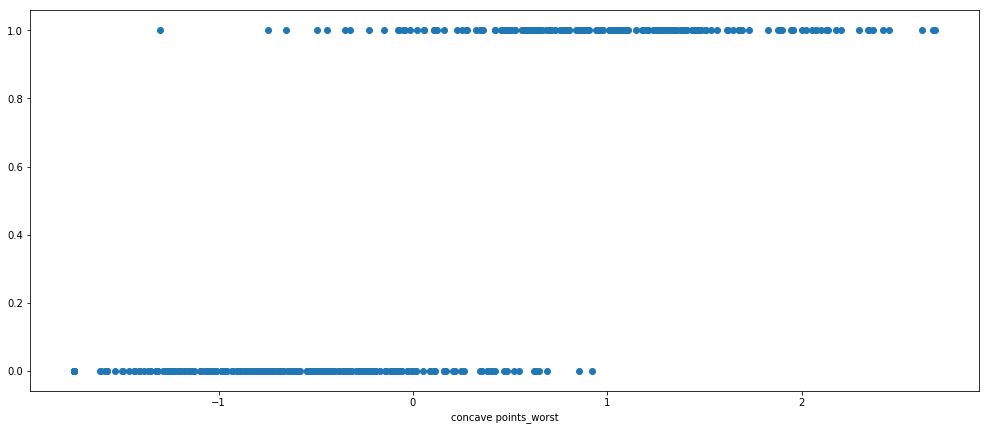

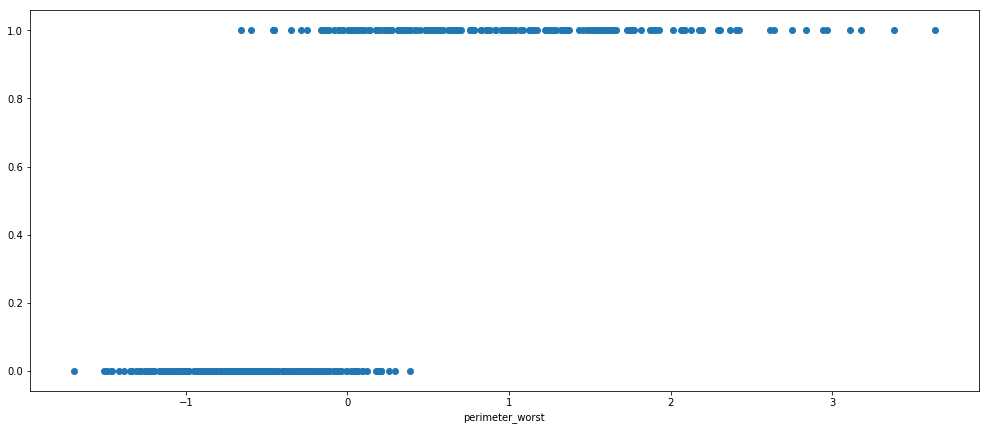

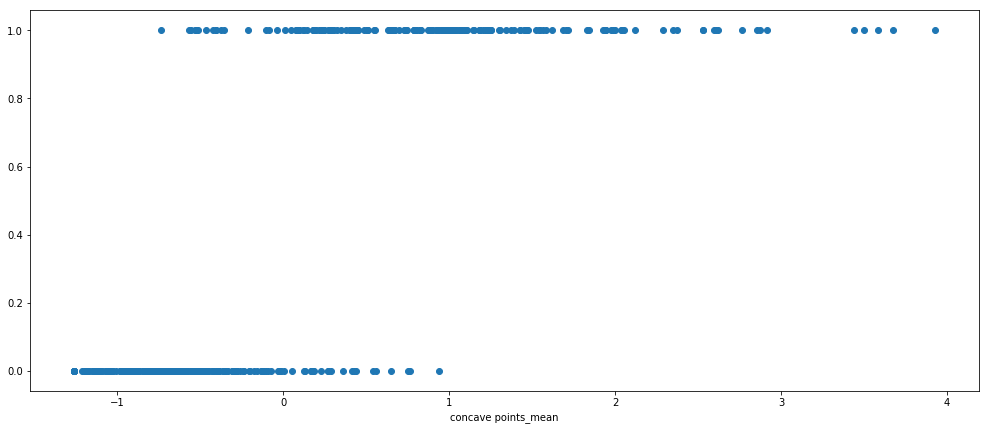

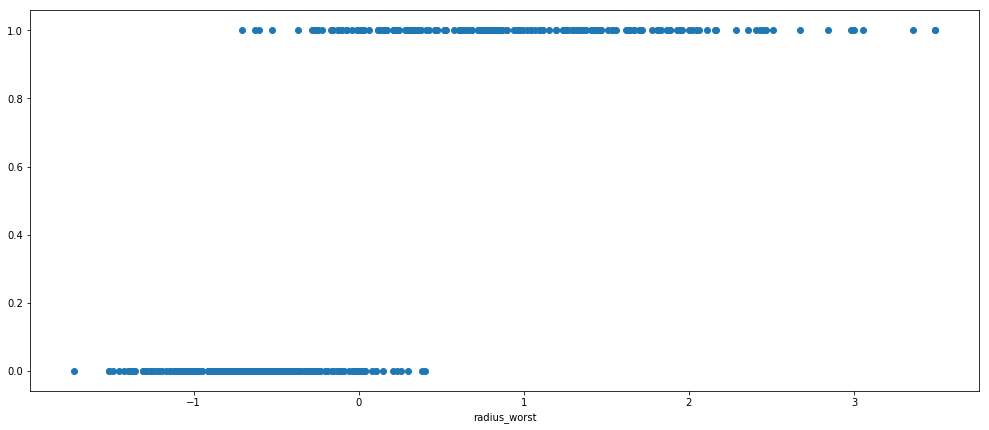

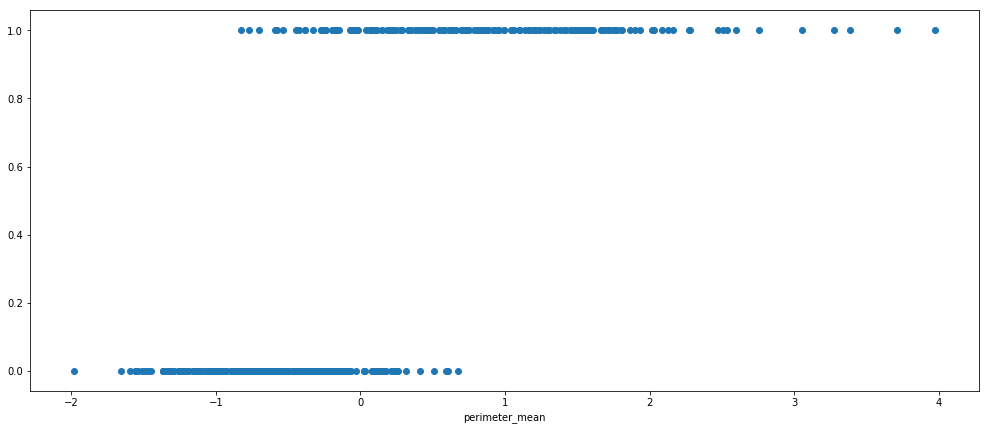

In [75]:
# let's look at how the 5 most correlated features are associated with malignancy

for i in range(5):
# for i in corr_columns[:5]:
    plt.scatter(data_train[:,corr_columns[i]], diag_train)
    plt.xlabel(corr_column_names[i])
    plt.rcParams['figure.figsize'] = [17,7]
    plt.show()

In [76]:
# let's take the most correlated features
most_corr = corr_columns[:20]
# let's remove features which are highly correlated

In [77]:
most_corr

[27, 22, 7, 20, 2, 23, 0, 3, 6, 26, 5, 25, 10, 12, 13, 21, 24, 28, 1, 17]

In [78]:
# an analytical solution, scales well at larger feature sizes
def most_corr_features(most_corr):
    corr_matrix = np.zeros((len(most_corr),len(most_corr)))
    for i in range(len(most_corr)):
        for j in range(len(most_corr)):
            ind1 = most_corr[i]
            ind2 = most_corr[j]
            corr_matrix[i,j] = round(np.corrcoef(data_train[:,ind1],data_train[:,ind2])[0,1],2)
# correlation matrix is symmetrical, so we can think of it as upper triangular, and ignore the diagonal
    corr_matrix = np.triu(corr_matrix,1)
    # find the coordinates of the max value
    # these are the features most correlated to each other
    print('correlation coefficient:', np.amax(corr_matrix)) # how correlated the features are
    x,y = np.argmax(corr_matrix) // len(corr_matrix) ,np.argmax(corr_matrix) % len(corr_matrix) # argmax flattens the indices
    return x, corr_column_names[most_corr[x]], y, corr_column_names[most_corr[y]]  # most correlated features, with indices

In [79]:
# let's eliminate correlated features one at a time until we reach a featureset we are happy with
# eliminate feature further in list, as features are sorted by how correlated to labels, we'd rather keep 1st

In [80]:
# repeat until features become less correlated, 15th in line, correlation coefficient: 0.58
for _ in range(14):
    _,_,y,_ = most_corr_features(most_corr)
    del most_corr[y]
    len(most_corr)

correlation coefficient: 1.0
correlation coefficient: 0.99
correlation coefficient: 0.99
correlation coefficient: 0.98
correlation coefficient: 0.97
correlation coefficient: 0.97
correlation coefficient: 0.95
correlation coefficient: 0.92
correlation coefficient: 0.91
correlation coefficient: 0.9
correlation coefficient: 0.89
correlation coefficient: 0.86
correlation coefficient: 0.82
correlation coefficient: 0.81


In [81]:
most_corr # position in corr_column_names, not original dataframe columns

[27, 10, 21, 24, 28, 17]

In [82]:
current_features = []
for i in most_corr:
    current_features.append(corr_column_names[i])
print(current_features)

['texture_se', 'compactness_mean', 'symmetry_mean', 'concavity_se', 'fractal_dimension_mean', 'symmetry_worst']


In [83]:
# take a list of features and return list of columns
def feat_to_col(current_features):
    data_frame = data.drop(columns=['Unnamed: 32', 'id', 'diagnosis'])
    return [data_frame.columns.get_loc(i) for i in current_features]

# current_features = corr_column_names[:10] # use first 10 candidate features 
current_features = ['texture_se', 'compactness_mean', 'symmetry_mean', 'concavity_se', 'fractal_dimension_mean', 'symmetry_worst']
feature_list = feat_to_col(current_features)
print(feature_list)

[11, 5, 8, 16, 9, 28]


In [84]:
# preprocessing, create an np array len(data_train), by len(current_features)
# fill from columns defined by current_features

num_features = len(current_features)
X_train = np.zeros((len(data_train),num_features))
X_test = np.zeros((len(data_test),num_features))
for i in range(len(data_train)):
    for j in range(num_features):
        col = feature_list[j]
        X_train[i,j] = data_train[i,col]
for i in range(len(data_test)):
    for j in range(num_features):
        col = feature_list[j]
        X_test[i,j] = data_train[i,col]
        
Y_train = np.array(diag_train)
Y_test = np.array(diag_test)

In [85]:
# Same but with scaled data

num_features = len(current_features)
X_train_scaled = np.zeros((len(data_train_scaled),num_features))
X_test_scaled = np.zeros((len(data_test_scaled),num_features))
for i in range(len(data_train_scaled)):
    for j in range(num_features):
        col = feature_list[j]
        X_train_scaled[i,j] = data_train_scaled[i,col]
for i in range(len(data_test_scaled)):
    for j in range(num_features):
        col = feature_list[j]
        X_test_scaled[i,j] = data_train_scaled[i,col]
        
Y_train = np.array(diag_train)
Y_test = np.array(diag_test)

In [86]:
# setting up some functions for processing and analyzing data

In [87]:
# convert a regressor to a binary prediction at some cutoff
def to_binary_pred(prediction,cutoff=.5):
    pred_binary = np.zeros(len(prediction))
    for i in range(len(prediction)):
        if prediction[i] > cutoff:
            pred_binary[i] = 1
        else:
            pred_binary[i] = 0
    return pred_binary

In [88]:
def roc(predict, answers=Y_test, k = None ,samples = 21):
    ''' takes answers, a np array
    returns two lists, true positive rate(sensitivity), 
    false positive rate(1-specificity)
    at a range of cutoffs'''
    tpr = []
    fpr = []
    poss_cutoff = np.linspace(0,1,samples)
    if k: poss_cutoff = [k]
    for k in poss_cutoff: 
        true_benign = 0
        true_mal = 0
        correct_benign = 0
        correct_mal = 0
        for i in range(len(answers)):
            if answers[i] == 1 and predict[i] > k:
                correct_mal += 1
                true_mal += 1
            elif answers[i] == 0 and predict[i] <= k: 
                correct_benign += 1
                true_benign += 1
            elif answers[i] == 0:
                true_benign +=1
            else:                 #  diag_test[i] == 1
                true_mal +=1
    #     roc[k] = (correct_mal/true_mal, correct_benign/true_benign)
        tpr.append(correct_mal/true_mal)
        fpr.append(1-correct_benign/true_benign)
#     print('tp',correct_mal,'fn',true_mal-correct_mal,'tn',correct_benign, 'fp',true_benign-correct_benign) # debug
    return fpr, tpr

Although the problem is fundamentally one of classification, Regression techniques are useful here.  Outputting 0 or 1 output may be satisfactory.  However, scaling the output from 0 to 1 based on how certain the sample belongs to each class allows some insight to the user.  Additionally, we may choose the cutoff value, depending on clinical need, as will be illustrated further below with Receiver Operating Characteristic (ROC) curves.  

In [89]:
#Support Vector Regression
clf = SVR(kernel='linear', gamma='scale', C=1)
clf.fit(X_train_scaled, Y_train)

pred = clf.predict(X_test_scaled)

In [90]:
def plot_roc(pred,title='ROC Curve', points=21, figsize=[17,7]):
    fpr, tpr = roc(pred,samples= points)
    names = [str(i) for i in range(len(tpr))]
    plt.ylabel('true positive rate')
    plt.xlabel('false positive = 1 - specificity')
    plt.scatter(fpr,tpr, s= 10)
    # annotations = string, (x,y)
    for i in range(len(tpr)):
        plt.annotate(names[i],(fpr[i],tpr[i]))
    plt.rcParams['figure.figsize'] = figsize
    plt.title(title)

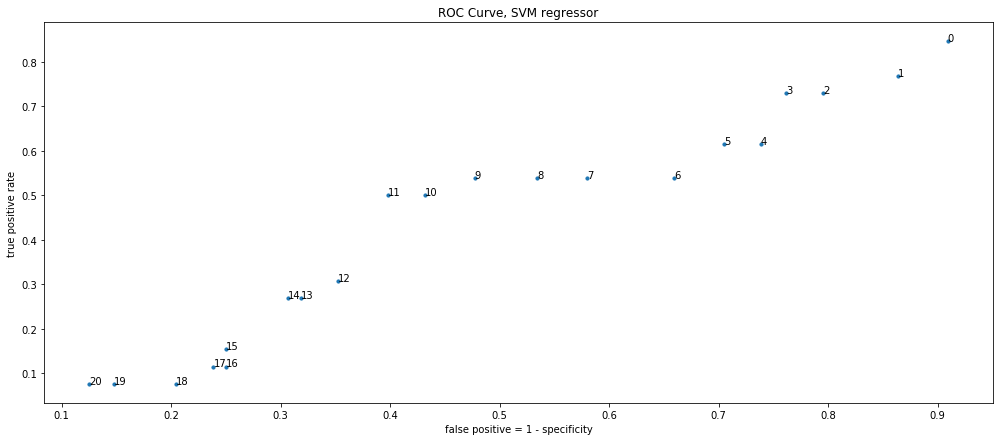

In [91]:
plot_roc(pred,title="ROC Curve, SVM regressor")
# plt.savefig('/home/david/keras/kaggle/svr.png')

In [92]:
# calculate area under roc curve to quantify performance of classification model, 
# closer to 1 is better
fpr,tpr = roc(pred)
print('area under ROC curve:',sk.metrics.auc(fpr,tpr))

area under ROC curve: 0.36778846153846156


In [93]:
pred_bin = to_binary_pred(pred,cutoff=.55)

conf_matrix = sk.metrics.confusion_matrix(Y_test, pred_bin, labels=[1,0] )
conf_matrix = conf_matrix.transpose()
print(conf_matrix)
sens = conf_matrix[0,0]/np.sum(conf_matrix[:,0])
spec = conf_matrix[1,1]/np.sum(conf_matrix[:,1])
print('sensitivity:', sens)
print('specificity:', spec,end='\n\n')

print('accuracy:', sk.metrics.accuracy_score(diag_test, pred_bin))
print('f1 score:', sk.metrics.f1_score(diag_test, pred_bin))

[[13 35]
 [13 53]]
sensitivity: 0.5
specificity: 0.6022727272727273

accuracy: 0.5789473684210527
f1 score: 0.35135135135135137


Let's take another approach to dimensionality reduction  
Using sklearn's KernelPCA which can apply nonlinear transformations

In [110]:
kpca = KernelPCA(n_components=14, kernel='sigmoid', gamma=15)
X_kpca =  kpca.fit_transform(data_train)
X_kpca_test = kpca.transform(data_test)

In [111]:
clf = SVR(gamma='scale', C=1)
clf.fit(X_kpca, Y_train)

pred = clf.predict(X_kpca_test)

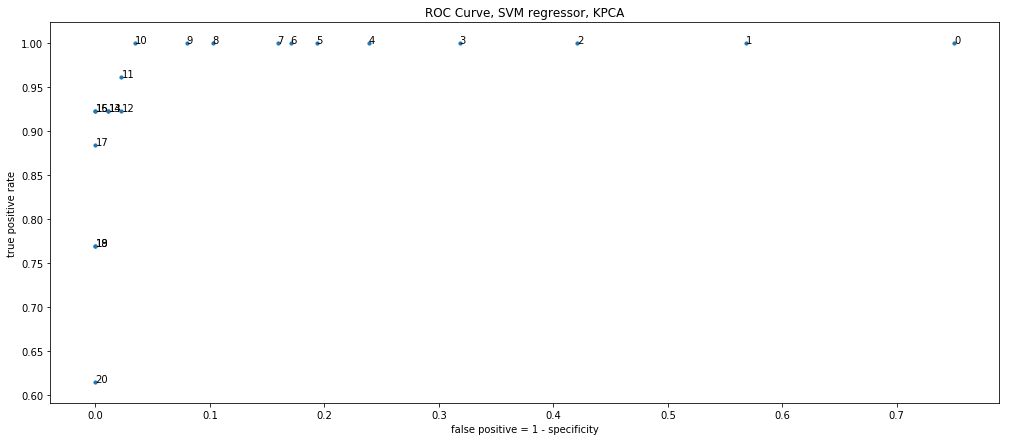

In [112]:
plot_roc(pred,title="ROC Curve, SVM regressor, KPCA")

In [113]:
fpr,tpr = roc(pred)
print('area under ROC curve:',sk.metrics.auc(fpr,tpr))

area under ROC curve: 0.7480332167832168


In [114]:
pred_bin = to_binary_pred(pred,cutoff=.6)

conf_matrix = sk.metrics.confusion_matrix(Y_test, pred_bin, labels=[1,0] )
conf_matrix = conf_matrix.transpose()
print(conf_matrix)
sens = conf_matrix[0,0]/np.sum(conf_matrix[:,0])
spec = conf_matrix[1,1]/np.sum(conf_matrix[:,1])
print('sensitivity:', sens)
print('specificity:', spec,end='\n\n')
print('accuracy:', sk.metrics.accuracy_score(Y_test,pred_bin))
print('f1 score:', sk.metrics.f1_score(Y_test,pred_bin))

[[24  2]
 [ 2 86]]
sensitivity: 0.9230769230769231
specificity: 0.9772727272727273

accuracy: 0.9649122807017544
f1 score: 0.9230769230769231


Now, let's use Keras to create a deep learning network  
the input_shape is the number of features we're using
here I have 4 hidden layers of size 30
and 1 output layer, with a single node

The advantages of deep learning networks is that they can create their own nonlinear feature sets by combining the inputs into hidden layers.  This can alleviate the work of feature engineering.  

To prevent overfitting we tune the hyperparameters of the model.  Here I applied a regularization term to the final layer.  One could use a regularization term on each layer with a correspondingly lower value (lambda).  

Think of regularization as penalizing the weight matrix of the model.  If lambda is low, the model is not penalized for applying value to the noise.  If lambda is high, the model underfits the data, as it prefers smaller weights.

In [115]:
model = models.Sequential()
model.add(layers.Dense(30, activation = 'relu', input_shape = (30,))) # input 1 for test, 30 for all features
model.add(layers.Dense(30, activation = 'relu',))
model.add(layers.Dense(30, activation = 'relu',))
model.add(layers.Dense(30, activation = 'relu',))
model.add(layers.Dense(1, activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.03)))

The output layer of the neural net above is a single node.  
Its uses the sigmoid activation, to constrain its output between 0 and 1  
0 the model is confident the features represent a benign sample  
1 the model is confident the sample is malignant

Further below we will plot a ROC curve, and evaluate how to choose a cutoff value somewhere between 0 and 1

In [116]:
model.compile(optimizer=optimizers.RMSprop(lr=.001),
             loss = losses.binary_crossentropy,   # test this
             metrics = [metrics.binary_accuracy])

In [117]:
start = timeit.default_timer()
model.fit(data_train,
         diag_train,
         epochs = 30,
         batch_size = 32,
         #validation_data = ()
         verbose = 2)
end = timeit.default_timer()

Epoch 1/30
 - 0s - loss: 0.6245 - binary_accuracy: 0.8198
Epoch 2/30
 - 0s - loss: 0.3632 - binary_accuracy: 0.9385
Epoch 3/30
 - 0s - loss: 0.2204 - binary_accuracy: 0.9604
Epoch 4/30
 - 0s - loss: 0.1580 - binary_accuracy: 0.9692
Epoch 5/30
 - 0s - loss: 0.1283 - binary_accuracy: 0.9714
Epoch 6/30
 - 0s - loss: 0.1124 - binary_accuracy: 0.9780
Epoch 7/30
 - 0s - loss: 0.1025 - binary_accuracy: 0.9824
Epoch 8/30
 - 0s - loss: 0.0929 - binary_accuracy: 0.9802
Epoch 9/30
 - 0s - loss: 0.0853 - binary_accuracy: 0.9846
Epoch 10/30
 - 0s - loss: 0.0795 - binary_accuracy: 0.9846
Epoch 11/30
 - 0s - loss: 0.0751 - binary_accuracy: 0.9868
Epoch 12/30
 - 0s - loss: 0.0699 - binary_accuracy: 0.9890
Epoch 13/30
 - 0s - loss: 0.0661 - binary_accuracy: 0.9890
Epoch 14/30
 - 0s - loss: 0.0621 - binary_accuracy: 0.9890
Epoch 15/30
 - 0s - loss: 0.0574 - binary_accuracy: 0.9890
Epoch 16/30
 - 0s - loss: 0.0549 - binary_accuracy: 0.9890
Epoch 17/30
 - 0s - loss: 0.0497 - binary_accuracy: 0.9912
Epoch 

In [118]:
print('training time:', end - start)

training time: 1.9788051569994423


In [119]:
acc = model.history
acc.history.keys()

dict_keys(['loss', 'binary_accuracy'])

Text(0, 0.5, 'accuracy on training set')

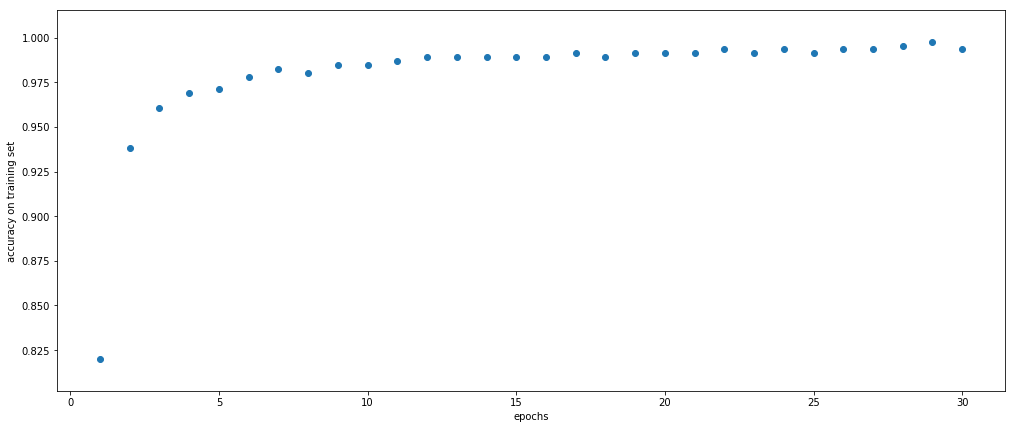

In [120]:
epochs = 30
x_vals = list(range(1,epochs+1))
y_vals = acc.history['binary_accuracy']
plt.scatter(x_vals,y_vals)
plt.xlabel('epochs')
plt.ylabel('accuracy on training set')

In [121]:
# model.save('/home/david/keras/kaggle/dnn')

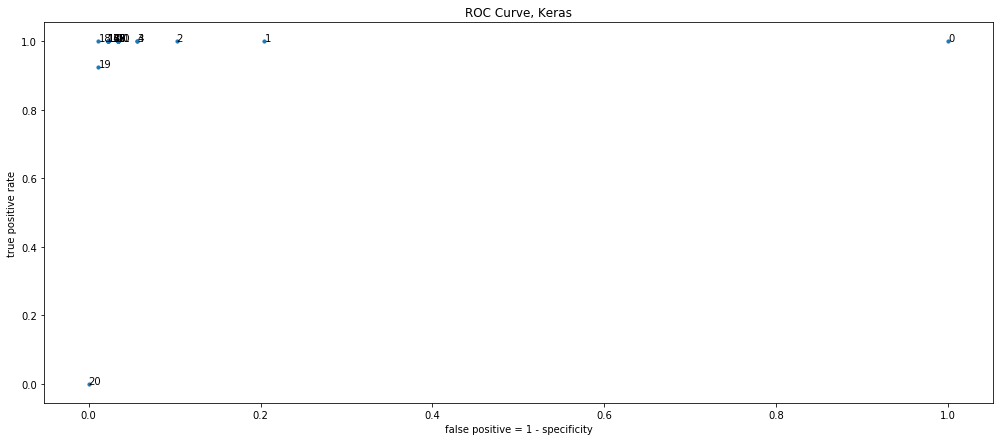

In [122]:
pred = model.predict(data_test)
plot_roc(pred,title="ROC Curve, Keras")
# plt.savefig('/home/david/keras/kaggle/roc.png')

In [123]:
# here pt 17 is best, corresponding to a cutoff of 0.85

In [124]:
fpr,tpr = roc(pred)
print('area under ROC curve:',sk.metrics.auc(fpr,tpr))

area under ROC curve: 0.9938811188811189


In [125]:
pred_binary = to_binary_pred(pred,cutoff=.85)

conf_matrix = sk.metrics.confusion_matrix(diag_test, pred_binary, labels=[1,0] )
conf_matrix = conf_matrix.transpose()
print(conf_matrix,end='\n\n')
sens = conf_matrix[0,0]/np.sum(conf_matrix[:,0])
spec = conf_matrix[1,1]/np.sum(conf_matrix[:,1])

print('sensitivity:', sens)
print('specificity:', (1-spec),end='\n\n')

print('accuracy:', sk.metrics.accuracy_score(diag_test, pred_binary))
print('f1 score:', sk.metrics.f1_score(diag_test, pred_binary))

[[26  2]
 [ 0 86]]

sensitivity: 1.0
specificity: 0.022727272727272707

accuracy: 0.9824561403508771
f1 score: 0.962962962962963


In [126]:
# display the sensitivities and specificities for points above
fpr, tpr = roc(pred)
[(round(tpr[i],2), round(1-fpr[i],2))for i in [17]]

[(1.0, 0.98)]

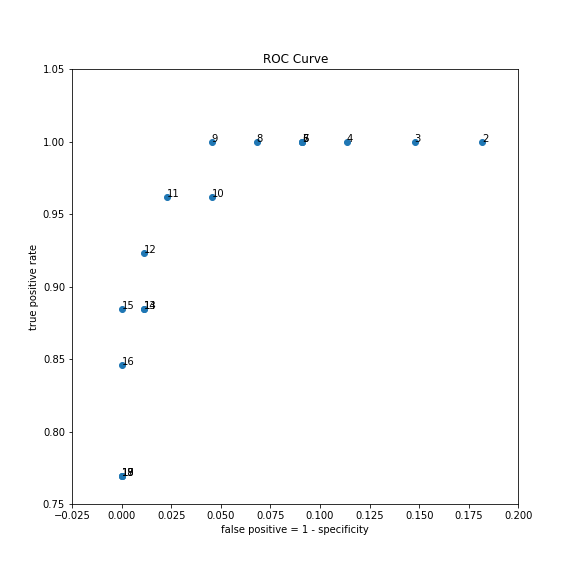

In [127]:
from IPython.display import Image
Image('/home/david/keras/kaggle/roc_nonnormalized_section.png')

ROC curve above is from a model trained on nonnormalized data, it more fully illustrates the tradeoffs of choosing a cutoff value.

Points 0 through 20 represent increasing cutoff values for our test, from 0 to 1:  
At 0 every sample is declared malignant, so sensitivity is 100%, but the false positive rate is 100% as well
At 1 every sample is declared benign, so sensitivity should be 0%, but the false positive rate is also 0%

Between these values, as we increase the cutoff, we decrease the false positive rate,
and beyond a certain point this comes at the expense of decreasing the true positive rate

pt 9 is better than 2-8
pt 11 is better than 10

So we have a choice between cutoffs of .45, and .55

It's important to pause here and think about what we want from our model.

* Sensitivity: the proportion of the affected population that is diagnosed correctly  
    * As sensitivity increases, more patients who need treatment receive it.
    

* Specificity: the proportion of the unaffected population that is diagnosed correctly  
    * As specificity increases, fewer patients are falsely reassured and don't receive needed treatment.

* We may prefer sensitivity to specificity, depeneding on how steep the tradeoff is.
    * For a serious condition like breast cancer, this would require more biopsies, and needlessly worry more patients, at the expense of not missing patients who need treatment. 

Another option, is for samples close to our desired cutoff to recommend careful observation.  This would make most sense when other evidence from a mammogram, or ultrasound suggests the mass is benign

To check the utility of the above analysis let's compare to clinical data.  
https://www.ncbi.nlm.nih.gov/pubmed/17986804  
This is a study of 382 cases of FNA of suspicious breast lesions.  
They report sensitivity of 86.3%, specificity of 98.2%, and accuracy of 93.2%

Our model compares favorably to the clinical results.  We obtain a higher sensitivity without loss of specificity.